In [87]:
#importing libraries
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
import urllib.request


In [88]:

# Download the dataset from GitHub
!curl -L -o human_behavior_dataset.csv https://raw.githubusercontent.com/amnafatimaa6-ops/data-visualization/main/human_behavior_dataset.csv

# Load it into a DataFrame
df = pd.read_csv('human_behavior_dataset.csv')
df.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8913  100  8913    0     0   101k      0 --:--:-- --:--:-- --:--:--  102k


,Date,Stress_Level,Sleep_Hours,Screen_Time_Hours,Caffeine_Intake_Cups,Mood_Score,Daily_Steps,Primary_Activity
0,2024-01-01,7,8.3,5.6,0,NaN,5752.0,Gaming
1,2024-01-02,4,5.9,8.4,1,1.0,10828.0,Workout
2,2024-01-03,8,5.8,6.8,1,9.0,6618.0,Gaming
3,2024-01-04,5,7.1,6.0,0,1.0,7434.0,Workout
4,2024-01-05,7,9.4,5.1,5,4.0,8740.0,Reading


In [89]:
#checking data first
df.describe
df.columns
print(df.dtypes)
print('number of duplicates',df.duplicated().sum())
print('number of null values', df.isnull().sum())
print(df['Primary_Activity'].unique())
print(df['Caffeine_Intake_Cups'].unique())


Date                     object
Stress_Level              int64
Sleep_Hours             float64
Screen_Time_Hours       float64
Caffeine_Intake_Cups      int64
Mood_Score              float64
Daily_Steps             float64
Primary_Activity         object
dtype: object
number of duplicates 10
number of null values Date                    0
Stress_Level            0
Sleep_Hours             5
Screen_Time_Hours       0
Caffeine_Intake_Cups    0
Mood_Score              5
Daily_Steps             5
Primary_Activity        0
dtype: int64
['Gaming' 'Workout' 'Reading' 'Sleeping' 'Travel' 'Studying']
[0 1 5 2 3 6 4 8]


In [90]:
#cleaning data
df = df.drop_duplicates() #dropping duplicates
print("Duplicate rows after:", df.duplicated().sum())
#filling nan
numeric_cols = ['Stress_Level',"Sleep_Hours", "Screen_Time_Hours", "Caffeine_Intake_Cups", "Mood_Score", "Daily_Steps"]
for col in numeric_cols:
  df[col].fillna(df[col].mean(), inplace = True)
categorical_cols = ["Primary_Activity"]
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
df['Primary_Activity'] = df['Primary_Activity'].str.title()

print(df.isna().sum())
print(df.duplicated().sum())
print(df['Primary_Activity'].unique())

Duplicate rows after: 0
Date                    0
Stress_Level            0
Sleep_Hours             0
Screen_Time_Hours       0
Caffeine_Intake_Cups    0
Mood_Score              0
Daily_Steps             0
Primary_Activity        0
dtype: int64
0
['Gaming' 'Workout' 'Reading' 'Sleeping' 'Travel' 'Studying']


/tmp/ipython-input-1892372614.py:7: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-1892372614.py:10: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or 

One-Tailed Z-Test (H1: mean > 7000)
Z-value: 0.87449164795358
P-value: 0.19092528332469028
Fail to reject H₀: Average daily steps is NOT significantly greater than 7000


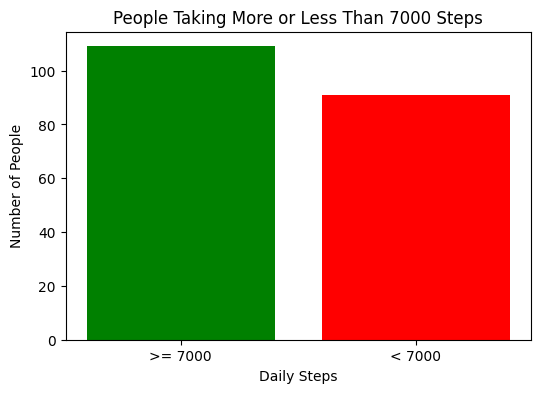

In [91]:
#HYPOTHESIS
# Z-TEST
'''
A Z-test is a statistical test used to determine if the mean of a sample is significantly different from a known population mean.
It’s used when the population standard deviation is known.
The sample size is relatively large (n > 30 is a common rule)
'''
#claim:average person takes 7000 or more steps per day
sample_col = 'Daily_Steps'
sample_mean = df[sample_col].mean()
n = df[sample_col].shape[0]
# Population stats (known or assumed)
population_mean = 7000
population_std = 2000  # assumed known
alpha = 0.05  # significance level
# One-tailed Z-test (H1: mean > 7000)
#calculate Z-statistic
z_stat = (sample_mean - population_mean) / (population_std / np.sqrt(n))
#calculate p-value
p_value = 1 - norm.cdf(z_stat)  # one-tailed: check if mean > 7000

print("One-Tailed Z-Test (H1: mean > 7000)")
print("Z-value:", z_stat)
print("P-value:", p_value)

if p_value < alpha:
    print("Reject H₀: Average daily steps is significantly greater than 7000")
else:
    print("Fail to reject H₀: Average daily steps is NOT significantly greater than 7000")

#bar plot to check steps count above or less than 7000
# Create the step category
df['Step_Category'] = np.where(df['Daily_Steps'] >= 7000, '>= 7000', '< 7000')
# Count how many people in each category
step_counts = df['Step_Category'].value_counts()
plt.figure(figsize=(6,4))
plt.bar(step_counts.index, step_counts.values, color=['green','red'])
plt.title('People Taking More or Less Than 7000 Steps')
plt.xlabel('Daily Steps')
plt.ylabel('Number of People')
plt.show()

In [80]:
# Z-test
#Average stress level of humans is 6
col = 'Stress_Level'
sample_mean = df[col].mean()
sample_std = df[col].std()
n = df[col].shape[0]
#Assumed population std
population_std = 2
population_mean = 6

z_stats = (sample_mean - population_mean) / (sample_std/np.sqrt(n))
print("Z-value:", z_stat)
p_value = 2 * (1 - norm.cdf(abs(z_stat)))
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Reject H₀: Stress level is significantly different from 6")
else:
    print("Fail to reject H₀: Stress level is NOT significantly different from 6")



# Count how many people are at each stress level
stress_counts = df['Stress_Level'].value_counts().sort_index()

# For density curve
stress_values = df['Stress_Level']
kde = gaussian_kde(stress_values)
x_vals = np.linspace(min(stress_values), max(stress_values), 100)
y_vals = kde(x_vals)

# Histogram bars + density line
fig = px.bar(x=stress_counts.index, y=stress_counts.values,
             labels={'x':'Stress Level', 'y':'Count'},
             title='Stress Level Distribution with Density Curve',
             color_discrete_sequence=['skyblue'])

# Add density curve
fig.add_scatter(x=x_vals, y=y_vals*len(df), mode='lines', line=dict(color='red', width=2), name='Density Curve')

fig.show()



Z-value: 0.87449164795358
P-value: 0.38185056664938055
Fail to reject H₀: Stress level is NOT significantly different from 6


In [81]:
#T-TEST
'''
Used when population standard deviation is unknown or sample size is small (n < 30).
Tests if the sample mean is significantly different from a known value (one-sample) or if two sample means differ (two-sample).
'''
#does student sleep ,on average 7 hours per day?
sample_col = 'Sleep_Hours'
sam_mean = df[sample_col].mean()
sample_std = df[sample_col].std()
n = df[sample_col].shape[0]
# Population mean (hypothetical)
population_mean = 7
# Significance level
alpha = 0.05
#Calculate T-statistic
t_stat = (sam_mean - population_mean) / (sample_std / (n ** 0.5))
print("T-value:", t_stat)

#Calculate p-value (two-tailed)
p_value = 2 * (1 - t.cdf(abs(t_stat), df=n-1))
print("p-value:", p_value)

#Hypothesis decision
if p_value < alpha:
    print("Reject H₀: Mean sleep hours is significantly different from 7")
else:
    print("Fail to reject H₀: Mean sleep hours is not significantly different from 7")


#violin plot to check if people sleep more or less than 7
# Create a new column to classify sleep relative to 7 hours
df['Sleep_Category'] = np.where(df['Sleep_Hours'] >= 7, '>= 7 hours', '< 7 hours')
fig = px.violin(df, x='Primary_Activity', y='Sleep_Hours', color='Sleep_Category',
                box=True, points='all', hover_data=['Sleep_Hours'],
                title='Sleep Hours Distribution Across Activities: Above or Below 7 Hours',
                color_discrete_map={'< 7 hours':'red', '>= 7 hours':'green'})
fig.add_shape(type='line', x0=-0.5, x1=len(df['Primary_Activity'].unique())-0.5,
              y0=7, y1=7,
              line=dict(color='blue', dash='dash'),
              xref='x', yref='y')

fig.show()

T-value: -4.561563008822338
p-value: 8.86739581318352e-06
Reject H₀: Mean sleep hours is significantly different from 7


In [82]:
#ANNOVA-TEST(one way)
'''
ANOVA is a test that compares the means of three or more groups to check if they are different from each other.
'''
# does the type of primary activity affect how much people sleep?
gaming = df[df['Primary_Activity'] == 'Gaming']['Sleep_Hours']
workout = df[df['Primary_Activity'] == 'Workout']['Sleep_Hours']
reading = df[df['Primary_Activity'] == 'Reading']['Sleep_Hours']

f_stat, p_value = f_oneway(gaming, workout, reading)
print("F-statistic:", f_stat)
print("P-value:", p_value)
alpha = 0.05

if p_value < alpha:
    print("Reject H₀: At least one activity group has different mean sleep hours.")
else:
    print("Fail to reject H₀: No significant difference in sleep hours across activities.")


#box plot visualization of distribution of sleep in type of primary activities
fig = px.box(df, x='Primary_Activity', y='Sleep_Hours',
             color='Primary_Activity',
             title='Sleep Hours Across Different Activities',
             points="all")  # Shows all data points
fig.show()
#gaming max  and min sleep hours -->  3-9
#workout max and min sleep hours -->  4-9
#reading max and min sleep hours -->  2-11
#sleeping max and min sleep hours --> 1-9.7
#travel max and min sleep hours -->   3-9
#studying max and min hours -->       2-9.3

F-statistic: 1.5850112715024351
P-value: 0.2098557610406077
Fail to reject H₀: No significant difference in sleep hours across activities.


In [92]:
df

,Date,Stress_Level,Sleep_Hours,Screen_Time_Hours,Caffeine_Intake_Cups,Mood_Score,Daily_Steps,Primary_Activity,Step_Category
0,2024-01-01,7,8.3,5.6,0,5.451282,5752.0,Gaming,< 7000
1,2024-01-02,4,5.9,8.4,1,1.000000,10828.0,Workout,>= 7000
2,2024-01-03,8,5.8,6.8,1,9.000000,6618.0,Gaming,< 7000
3,2024-01-04,5,7.1,6.0,0,1.000000,7434.0,Workout,>= 7000
4,2024-01-05,7,9.4,5.1,5,4.000000,8740.0,Reading,>= 7000
...,...,...,...,...,...,...,...,...,...
195,2024-07-14,8,1.5,5.0,5,8.000000,5488.0,Sleeping,< 7000
196,2024-07-15,5,8.2,3.8,0,2.000000,8073.0,Gaming,>= 7000
197,2024-07-16,4,9.7,2.5,1,5.000000,5203.0,Sleeping,< 7000
198,2024-07-17,2,6.0,7.4,1,1.000000,7056.0,Travel,>= 7000


In [84]:
#CHI SQUARE TEST
'''
Chi-Square Test is a statistical test used to examine whether there is a significant association between categorical variables.
A contingency table is basically a way to organize and summarize categorical data to see how two (or more) variables relate to each other.
Chi-Square Test of Independence: Checks if two categorical variables are related or independent.
Chi-Square Goodness-of-Fit Test: Checks if the observed frequency of a single categorical variable matches an expected distribution.
'''
#claim: sleep and step are independent columns
# Create contingency table
contingency_table = pd.crosstab(df['Sleep_Category'], df['Step_Category'])
print(contingency_table)

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

# Hypothesis decision
alpha = 0.05
if p < alpha:
    print("Reject H₀: Sleep category and Step category are dependent")
else:
    print("Fail to reject H₀: Sleep category and Step category are independent")

fig = px.imshow(contingency_table.values,
                x=contingency_table.columns,
                y=contingency_table.index,
                text_auto=True,
                color_continuous_scale='Blues',
                labels=dict(x="Step Category", y="Sleep Category", color="Count"),
                title="Heatmap of Sleep Category vs Step Category")
fig.show()

Step_Category   < 7000  >= 7000
Sleep_Category                 
< 7 hours           57       62
>= 7 hours          34       47
Chi2 statistic: 0.46405765317183023
P-value: 0.4957337041793798
Degrees of freedom: 1
Expected frequencies:
[[54.145 64.855]
 [36.855 44.145]]
Fail to reject H₀: Sleep category and Step category are independent


In [85]:
# Making sure Date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Melt the dataframe to long format for multiple lines
df_melt = df.melt(id_vars='Date',
                  value_vars=['Sleep_Hours', 'Screen_Time_Hours', 'Daily_Steps'],
                  var_name='Metric',
                  value_name='Value')

# Create multi-line plot
fig = px.line(df_melt, x='Date', y='Value', color='Metric',
              title='Sleep, Screen Time, and Daily Steps Over Time',
              labels={'Date':'Date', 'Value':'Value', 'Metric':'Metric'},
              markers=True)  # dots on data points

fig.show()

In [86]:
#Five step  statistical summary for cols
numeric_columns = ['Stress_Level', 'Sleep_Hours', 'Screen_Time_Hours',
                   'Caffeine_Intake_Cups', 'Mood_Score', 'Daily_Steps']

# Loop through each column and create a box plot
for col in numeric_columns:
    fig = px.box(df, y=col, points="all",
                 title=f'Box Plot of {col} (5-number summary)',
                 labels={col: col})
    fig.show()